<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Word2Vect" data-toc-modified-id="Word2Vect-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word2Vect</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Cleaning" data-toc-modified-id="Cleaning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Cleaning</a></span></li><li><span><a href="#Bigrams" data-toc-modified-id="Bigrams-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Bigrams</a></span></li><li><span><a href="#Most-Frequent-Words" data-toc-modified-id="Most-Frequent-Words-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Most Frequent Words</a></span></li><li><span><a href="#Training-the-model" data-toc-modified-id="Training-the-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Training the model</a></span></li><li><span><a href="#Exploring-the-model" data-toc-modified-id="Exploring-the-model-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Exploring the model</a></span></li><li><span><a href="#t-SNE" data-toc-modified-id="t-SNE-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>t-SNE</a></span></li><li><span><a href="#10-Most-similar-words-vs.-8-Random-words" data-toc-modified-id="10-Most-similar-words-vs.-8-Random-words-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>10 Most similar words vs. 8 Random words</a></span></li><li><span><a href="#10-Most-similar-words-vs.-10-Most-dissimilar" data-toc-modified-id="10-Most-similar-words-vs.-10-Most-dissimilar-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>10 Most similar words vs. 10 Most dissimilar</a></span></li><li><span><a href="#References" data-toc-modified-id="References-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#Requirements" data-toc-modified-id="Requirements-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Requirements</a></span></li></ul></div>

# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Word embeddings with Word2Vect (introduced by Google) and t-SNE

</font>
</div>

# Word2Vect
<hr style="border:2px solid black"> </hr>

- The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning 
and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are 
often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according 
to Word2Vec they will therefore share a similar vector representation.

- From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the 
similarity between them, or use the vector representation of those words as input for other applications such
as text classification or clustering.

# Imports
<hr style="border:2px solid black"> </hr>

In [7]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from spacy.cli.download import download
import itertools

# Dataset
<hr style="border:2px solid black"> </hr>

In [2]:
"""
This dataset contains the characters, locations, episode details, and script lines for approximately 600
Simpsons episodes, dating back to 1989. It can be found here: 
https://www.kaggle.com/ambarish/fun-in-text-mining-with-simpsons/data (~25MB)
"""

In [2]:
df = pd.read_csv('../DATASETS/simpsons_dataset.csv')
df.shape

(158314, 2)

In [3]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
"""
The missing values comes from the part of the script where something happens, but with no dialogue. 
For instance "(Springfield Elementary School: EXT. ELEMENTARY - SCHOOL PLAYGROUND - AFTERNOON)"
"""

In [4]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [5]:
# Removing the missing values
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [6]:
# Checking again the dataset is cleaned from null values
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

# Cleaning
<hr style="border:2px solid black"> </hr>

In [ ]:
"""
We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.
LEMMANTISATION: Compare to stemming, lemmatization is a robust, efficient and methodical way of combining 
grammatical variations to the root of a word. The “lemma” for a word is the base word from which it is derived. 
Intuitively, if we are making a bag-of-words, then “running,” “ran,” and “runs” should all count the same.
"""

In [ ]:
"""
See this link on how to donwload the model
https://stackoverflow.com/questions/66087475/chatterbot-error-oserror-e941-cant-find-model-en
"""

In [8]:
download(model="en_core_web_sm")
# Disabling Named Entity Recognition for speed
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [27]:
# Removes non-alphabetic characters:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [32]:
# Let us visualise the result. I need to make a copy otherwise it changes the object type!
brief_cleaning, brief_cleaning2 = itertools.tee(brief_cleaning)
pd.DataFrame(brief_cleaning2)

,0
0,no actually it was a little of both sometimes ...
1,where's mr bergstrom
2,i don't know although i'd sure like to talk to...
3,that life is worth living
4,the polls will be open from now until the end ...
...,...
131848,i'm back
131849,you see class my lyme disease turned out to be
131850,psy cho so ma tic
131851,does that mean you were crazy


In [25]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long, the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [26]:
# Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.64 mins


In [29]:
# Put the results in a DataFrame to remove missing values and duplicates:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85956, 1)

In [33]:
df_clean

,clean
0,actually little disease magazine news show nat...
2,know sure like talk touch lesson plan teach
3,life worth live
4,poll open end recess case decide thought final...
7,victory party slide
...,...
131829,oh mom wonderful find favorite dish help
131835,dye shoe pink
131846,mr bergstrom request pleasure company mr bergs...
131849,class lyme disease turn


# Bigrams
<hr style="border:2px solid black"> </hr>

In [ ]:
"""
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !
"""

In [34]:
# Phrases() takes a list of list of words as input:
sent = [row.split() for row in df_clean['clean']]

In [35]:
# Creates the relevant phrases from the list of sentences
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 16:25:39: collecting all words and their counts
INFO - 16:25:39: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:25:39: PROGRESS: at sentence #10000, processed 63557 words and 52733 word types
INFO - 16:25:39: PROGRESS: at sentence #20000, processed 130938 words and 99702 word types
INFO - 16:25:39: PROGRESS: at sentence #30000, processed 192959 words and 138314 word types
INFO - 16:25:39: PROGRESS: at sentence #40000, processed 249828 words and 172378 word types
INFO - 16:25:39: PROGRESS: at sentence #50000, processed 311267 words and 208202 word types
INFO - 16:25:39: PROGRESS: at sentence #60000, processed 373573 words and 243255 word types
INFO - 16:25:39: PROGRESS: at sentence #70000, processed 436422 words and 278194 word types
INFO - 16:25:40: PROGRESS: at sentence #80000, processed 497885 words and 311308 word types
INFO - 16:25:40: collected 330094 token types (unigram + bigrams) from a corpus of 537096 words and 85956 sentences
INFO - 16:25:40: m

In [ ]:
"""
The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly 
needed for the bigram detection task:
"""

In [36]:
bigram = Phraser(phrases)

INFO - 16:25:43: exporting phrases from Phrases<330094 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 16:25:43: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<124 phrases, min_count=30, threshold=10.0> from Phrases<330094 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.69s', 'datetime': '2021-04-22T16:25:43.977902', 'gensim': '4.0.0', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.13.6-x86_64-i386-64bit', 'event': 'created'}


In [37]:
# Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

In [39]:
list(sentences)

[['actually',
  'little',
  'disease',
  'magazine',
  'news',
  'show',
  'natural',
  'think'],
 ['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach'],
 ['life', 'worth', 'live'],
 ['poll',
  'open',
  'end',
  'recess',
  'case',
  'decide',
  'thought',
  'final',
  'statement',
  'martin'],
 ['victory', 'party', 'slide'],
 ['mr', 'bergstrom', 'mr', 'bergstrom'],
 ['hey',
  'hey',
  'move',
  'morning',
  'new',
  'job',
  'take',
  'copernicus',
  'costume'],
 ['think', 'take', 'train', 'capital_city'],
 ['train', 'like', 'traditional', 'environmentally', 'sound'],
 ['yes',
  'backbone',
  'country',
  'leland',
  'stanford',
  'drive',
  'golden',
  'spike',
  'promontory',
  'point'],
 ['hey', 'thank', 'vote', 'man'],
 ['vote', 'voting', 'geek'],
 ['get', 'right', 'thank', 'vote', 'girl'],
 ['sweat', 'long', 'couple', 'people', 'right', 'milhouse'],
 ['martin', 'martin', 'like', 'recount'],
 ['want', 'sure', 'martin', 'martin'],
 ['way', 'mister', 'president'],
 [

# Most Frequent Words
<hr style="border:2px solid black"> </hr>

In [ ]:
"""
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.
"""

In [29]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29493

In [30]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

# Training the model
<hr style="border:2px solid black"> </hr>

In [ ]:
"""
We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html
3 distinctive steps for clarity and monitoring.

    Word2Vec():
        In this first step, I set up the parameters of the model one-by-one.
        I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.

    .build_vocab():
        Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
        With the loggings, I can follow the progress and even more important, the effect of min_count and 
        sample on the word corpus. I noticed that these two parameters, and in particular sample, have a 
        great influence over the performance of a model. Displaying both allows for a more accurate and 
        an easier management of their influence.

    .train():
        Finally, trains the model.
        The loggings here are mainly useful for monitoring, making sure that no threads are executed 
        instantaneously.
"""

In [42]:
# Count the number of cores in a computer
cores = multiprocessing.cpu_count() 
print(cores)

8


In [ ]:
"""
- min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
- window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words 
on the left and window words on the left of our target - (2, 10)
- size = int - Dimensionality of the feature vectors. - (50, 300)
- sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly 
  influencial. - (0, 1e-5)
- alpha = float - The initial learning rate - (0.01, 0.05)
- min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: 
  alpha - (min_alpha * epochs) ~ 0.00
- negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" 
  should be drown. If set to 0, no negative sampling is used. - (5, 20)
- workers = int - Use these many worker threads to train the model (=faster training with multicore machines)
"""

In [43]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 18:13:06: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2021-04-22T18:13:06.965314', 'gensim': '4.0.0', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.13.6-x86_64-i386-64bit', 'event': 'created'}


In [ ]:
"""
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique 
words, and doing some basic counts on them). progress_per controls the update frequency.
"""

In [46]:
t = time()
w2v_model.build_vocab(sentences, progress_per=5000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 18:14:01: collecting all words and their counts
INFO - 18:14:01: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:14:01: PROGRESS: at sentence #5000, processed 31994 words, keeping 6342 word types
INFO - 18:14:01: PROGRESS: at sentence #10000, processed 61705 words, keeping 9474 word types
INFO - 18:14:01: PROGRESS: at sentence #15000, processed 94344 words, keeping 11992 word types
INFO - 18:14:01: PROGRESS: at sentence #20000, processed 127321 words, keeping 14329 word types
INFO - 18:14:01: PROGRESS: at sentence #25000, processed 158033 words, keeping 15883 word types
INFO - 18:14:01: PROGRESS: at sentence #30000, processed 187814 words, keeping 17358 word types
INFO - 18:14:01: PROGRESS: at sentence #35000, processed 216177 words, keeping 18764 word types
INFO - 18:14:01: PROGRESS: at sentence #40000, processed 243317 words, keeping 20021 word types
INFO - 18:14:01: PROGRESS: at sentence #45000, processed 272754 words, keeping 21194 word types
INFO

Time to build vocab: 0.02 mins


In [ ]:
"""
Parameters of the training:
    total_examples = int - Count of sentences;
    epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]
"""

In [47]:
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 18:14:18: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 3316 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2', 'datetime': '2021-04-22T18:14:18.340964', 'gensim': '4.0.0', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.13.6-x86_64-i386-64bit', 'event': 'train'}
INFO - 18:14:19: worker thread finished; awaiting finish of 6 more threads
INFO - 18:14:19: worker thread finished; awaiting finish of 5 more threads
INFO - 18:14:19: worker thread finished; awaiting finish of 4 more threads
INFO - 18:14:19: worker thread finished; awaiting finish of 3 more threads
INFO - 18:14:19: worker thread finished; awaiting finish of 2 more threads
INFO - 18:14:19: worker thread finished; awaiting finish of 1 more threads
INFO - 18:14:19: worker thread finished; awaiting finish of 0 more threads
INFO - 18:14:19: EPOCH - 1 : training on 523625 raw words (199358 effective words) took 0.8s, 238721 effectiv

INFO - 18:14:30: worker thread finished; awaiting finish of 3 more threads
INFO - 18:14:30: worker thread finished; awaiting finish of 2 more threads
INFO - 18:14:30: worker thread finished; awaiting finish of 1 more threads
INFO - 18:14:30: worker thread finished; awaiting finish of 0 more threads
INFO - 18:14:30: EPOCH - 12 : training on 523625 raw words (199550 effective words) took 1.0s, 190154 effective words/s
INFO - 18:14:31: worker thread finished; awaiting finish of 6 more threads
INFO - 18:14:31: worker thread finished; awaiting finish of 5 more threads
INFO - 18:14:31: worker thread finished; awaiting finish of 4 more threads
INFO - 18:14:31: worker thread finished; awaiting finish of 3 more threads
INFO - 18:14:31: worker thread finished; awaiting finish of 2 more threads
INFO - 18:14:31: worker thread finished; awaiting finish of 1 more threads
INFO - 18:14:31: worker thread finished; awaiting finish of 0 more threads
INFO - 18:14:31: EPOCH - 13 : training on 523625 raw wo

INFO - 18:14:41: worker thread finished; awaiting finish of 4 more threads
INFO - 18:14:41: worker thread finished; awaiting finish of 3 more threads
INFO - 18:14:41: worker thread finished; awaiting finish of 2 more threads
INFO - 18:14:41: worker thread finished; awaiting finish of 1 more threads
INFO - 18:14:41: worker thread finished; awaiting finish of 0 more threads
INFO - 18:14:41: EPOCH - 24 : training on 523625 raw words (199508 effective words) took 0.8s, 235460 effective words/s
INFO - 18:14:42: EPOCH 25 - PROGRESS: at 93.83% examples, 181572 words/s, in_qsize 0, out_qsize 0
INFO - 18:14:42: worker thread finished; awaiting finish of 6 more threads
INFO - 18:14:42: worker thread finished; awaiting finish of 5 more threads
INFO - 18:14:42: worker thread finished; awaiting finish of 4 more threads
INFO - 18:14:42: worker thread finished; awaiting finish of 3 more threads
INFO - 18:14:42: worker thread finished; awaiting finish of 2 more threads
INFO - 18:14:42: worker thread f

Time to train the model: 0.49 mins


In [ ]:
"""
As we do not plan to train the model any further, we are calling init_sims(), which will make the model
much more memory-efficient:
"""

In [48]:
w2v_model.init_sims(replace=True)

<ipython-input-48-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
WARNING - 18:14:58: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


# Exploring the model
<hr style="border:2px solid black"> </hr>

In [41]:
"""
Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!
we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer"
"""

'\nHere, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!\nwe get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer"\n'

In [49]:
w2v_model.wv.most_similar(positive=["homer"])

[('depressed', 0.7025862336158752),
 ('marge', 0.6816842555999756),
 ('sweetheart', 0.6775771379470825),
 ('embarrassing', 0.6770950555801392),
 ('adopt', 0.6702985167503357),
 ('snuggle', 0.6653261184692383),
 ('wake', 0.6594128608703613),
 ('shoulda', 0.6571505665779114),
 ('gramma', 0.6565561294555664),
 ('gee', 0.6544002294540405)]

In [50]:
# Let's see what the bigram "homer_simpson" gives us by comparison:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('pleased', 0.718853235244751),
 ('congratulation', 0.6880443096160889),
 ('appearance', 0.6875929832458496),
 ('council', 0.6810144186019897),
 ('easily', 0.6756961345672607),
 ('select', 0.6734668612480164),
 ('recent', 0.6632207632064819),
 ('kennedy', 0.6497090458869934),
 ('erotic', 0.6493592858314514),
 ('committee', 0.648113489151001)]

In [51]:
# Here, we will see how similar are two words to each other
w2v_model.wv.similarity("maggie", 'baby')

0.67812693

In [52]:
# Here, we ask our model to give us the word that does not belong to the list!
# Between Jimbo, Milhouse, and Kearney, who is the one who is not a bully?
w2v_model.wv.doesnt_match(['homer', 'milhouse', 'bart'])

'homer'

In [53]:
# Which word is to woman as homer is to marge?
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('admire', 0.5768411159515381),
 ('attract', 0.5479364395141602),
 ('man', 0.5469537973403931)]

In [54]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.6682593822479248),
 ('pregnant', 0.6330554485321045),
 ('snuggle', 0.608863115310669)]

# t-SNE
<hr style="border:2px solid black"> </hr>

In [ ]:
"""
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data 
and the underlying relationships between vectors in a lower-dimensional space.

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot 
interesting patterns. For that we are going to use t-SNE implementation from scikit-learn.
To make the visualizations more relevant, we will look at the relationships between a query word (in **red**), 
its most similar words in the model (in **blue**), and other words from the vocabulary (in **green**).
"""

In [61]:
def tsnescatterplot(model, word, list_names, n_components):
    """t-SNE scatter plot
    Plot in seaborn the results from the t-SNE dimensionality 
    reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """

    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    # print(n_components = min(n_samples, n_features))
    reduc = PCA(n_components=n_components).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0,
             perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                  }
                     )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df['y'][line],
                '  ' + df["words"][line].title(),
                horizontalalignment='left',
                verticalalignment='bottom', size='medium',
                color=df['color'][line],
                weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min() - n_components, Y[:, 0].max() + n_components)
    plt.ylim(Y[:, 1].min() - n_components, Y[:, 1].max() + n_components)

    plt.title('t-SNE visualization for {}'.format(word.title()))

# 10 Most similar words vs. 8 Random words
<hr style="border:2px solid black"> </hr>

In [59]:
"""
Let's compare where the vector representation of Homer, his 10 most similar words from the model, 
as well as 8 random ones, lies in a 2D graph:
"""

"\nLet's compare where the vector representation of Homer, his 10 most similar words from the model, \nas well as 8 random ones, lies in a 2D graph:\n"

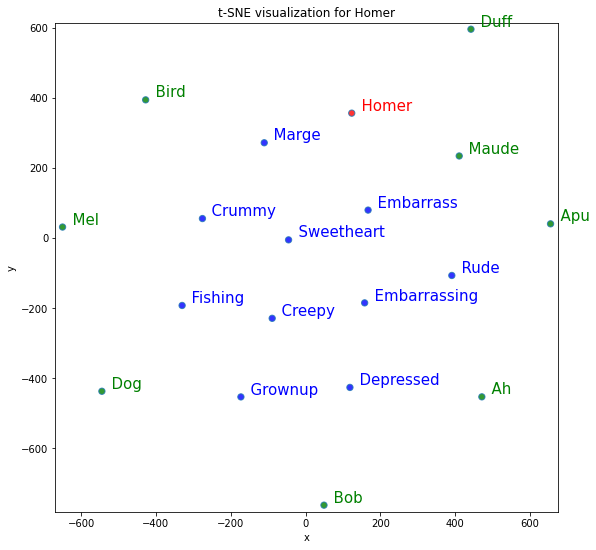

In [62]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'], 19)

# 10 Most similar words vs. 10 Most dissimilar
<hr style="border:2px solid black"> </hr>

In [ ]:
"""
This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model
lies compare to the vector representation of the 10 most dissimilar words to Maggie:
"""

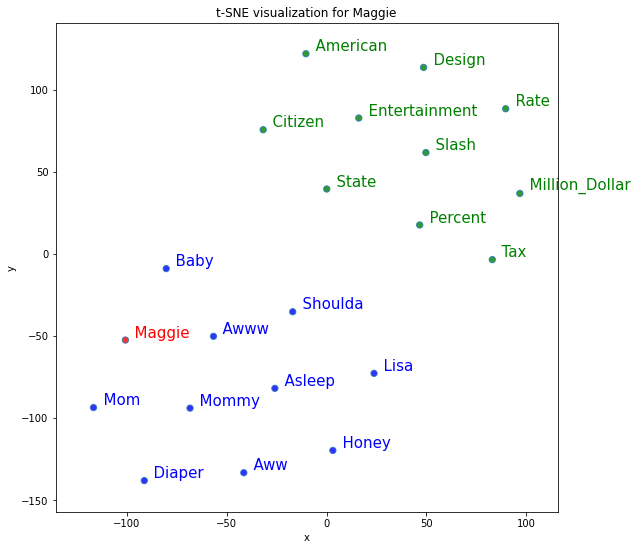

In [63]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])], 19)

# References
<hr style="border:2px solid black"> </hr>

- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial/notebook

# Requirements
<hr style="border:2px solid black"> </hr>

In [3]:
%load_ext watermark
%watermark -v -iv -m

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

json    : 2.0.9
numpy   : 1.21.6
autopep8: 1.6.0

